In [1]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')

In [2]:
import sys
sys.path.append('../code')
from dgp import DGP

gpflow.config.set_default_summary_fmt('notebook')
np.random.seed(0)
tf.random.set_seed(0)

## Load data

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_test = np.reshape(x_test,(x_test.shape[0],-1))

In [4]:
x_train.shape

(60000, 784)

In [5]:
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))

In [6]:
minibatch_size = 1000
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(10000)
#test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [7]:
N = x_train.shape[0]
D = x_train.shape[1]

## Define SVGP and DGP model

In [8]:
from scipy.stats import mode
from scipy.cluster.vq import kmeans2

In [9]:
# number of inducing points
M = 100
Z = kmeans2(x_train,M,minit='points')[0]

In [10]:
Z_500 = kmeans2(x_train,500,minit='points')[0]

In [13]:
invlink = gpflow.likelihoods.RobustMax(10)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(10, invlink=invlink)  # Multiclass likelihood
kernel = gpflow.kernels.SquaredExponential()

m = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variable=Z, num_latent=10, whiten=True, q_diag=True)

In [67]:
m_500 = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood,
    inducing_variable=Z_500, num_latent=10, whiten=True, q_diag=True)

In [11]:
def make_DGP(L):
    kernels = []
    for l in range(L):
        k = gpflow.kernels.SquaredExponential(variance=1., lengthscale=1.)
        kernels.append(k)
    dims = [784,]
    for l in range(L-1):
        dims.append(30)
    dims.append(10)
        
    m_dgp = DGP(x_train, y_train, Z, dims, kernels, likelihood,
                white=True, num_samples=1, num_data=N, minibatch_size=minibatch_size)
    
#     Initialise the layers to near deterministic
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = gpflow.base.Parameter(layer.q_sqrt.value() * 1e-5, 
                                 transform=gpflow.utilities.triangular())
    print(dims)
    return m_dgp

In [11]:
def make_DGP_ARD(L):
    dims = [784,]
    for l in range(L-1):
        dims.append(30)
    dims.append(10)
    
    kernels = []
    for dim in dims[:-1]:
        k = gpflow.kernels.SquaredExponential(variance=2., lengthscale=[2.]*dim)
        kernels.append(k)
        
    m_dgp = DGP(x_train, y_train, Z, dims, kernels, likelihood,
                white=True, num_samples=1, num_data=N, minibatch_size=minibatch_size)
    
#     Initialise the layers to near deterministic
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = gpflow.base.Parameter(layer.q_sqrt.value() * 1e-5, 
                                 transform=gpflow.utilities.triangular())
    print(dims)
    return m_dgp

In [12]:
dgp2_ard = make_DGP_ARD(2)

[784, 30, 10]


In [49]:
dgp3_ard = make_DGP_ARD(3)

[784, 30, 30, 10]


In [14]:
dgp4_adam = make_DGP(4)

[784, 30, 30, 30, 10]


In [15]:
gpflow.utilities.print_summary(m, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,True,(),float64,1.0
SVGP.kernel.lengthscale,Parameter,Softplus,True,(),float64,1.0
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
SVGP.inducing_variable.Z,Parameter,,True,"(100, 784)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,,True,"(100, 10)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,True,"(100, 10)",float64,"[[1., 1., 1...."


In [26]:
gpflow.utilities.print_summary(dgp2_ard, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.likelihood.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[2.36676417, -0.23564798, 0.2835507..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[0.30952549, 0., 0...."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0., 0., 0...."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,0.1584073926943575
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,"(784,)",float64,"[2., 2., 2...."
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[3.03878051e-19, -7.55026968e-20, 5.75681528e-19..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 10)",float64,"[[-1.12294483e+00, -9.73416314e-01, -7.69250276e-01..."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(10, 100, 100)",float64,"[[[2.06956232e-01, 0.00000000e+00, 0.00000000e+00..."


In [27]:
dgp2_ard.layers[0].kernel.lengthscale

<tf.Tensor: id=73601, shape=(784,), dtype=float64, numpy=
array([ 2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        , 25.91288312, 26.44983989, 26.57461283,
       25.9512387 ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        , 27.55487041, 25.3376792 , 28.39479478,
       29.37732237, 27.41358671, 27.99089279, 24.64642369, 25.65485189,
       24.30951496, 24.53609532, 24.1996056 , 21.93552587, 24.33961173,
       21.93981939, 23.37965302, 24.71670084, 25.46731404, 26.88708236,
       28.25496173, 27.20357025,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        , 28.03118672, 26.61831336,
       27.45442363, 29.33449147, 26.40279663, 26.26115598, 27.10793073,
      

In [38]:
gpflow.utilities.print_summary(dgp4_adam, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.likelihood.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[0.92516729, 0.45980384, 0.19885022..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[1.32192668e-01, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0., 0., 0...."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,0.20441919468826958
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,19.276758787729786
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[3.03878051e-19, -7.55026968e-20, 5.75681528e-19..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 30)",float64,"[[1.15057984, -0.02426888, 0.31675505..."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[5.11874524e-02, 0.00000000e+00, 0.00000000e+00..."


In [25]:
gpflow.utilities.print_summary(dgp3, fmt='notebook')

name,class,transform,trainable,shape,dtype,value
DGP.likelihood.likelihood.invlink.epsilon,Parameter,Sigmoid,False,(),float64,0.001000000047497451
DGP.layers[0].q_mu,Parameter,,True,"(100, 30)",float64,"[[1.00637317, 1.4872785, 0.62473869..."
DGP.layers[0].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[2.96488071e-01, 0.00000000e+00, 0.00000000e+00..."
DGP.layers[0].inducing_points.Z,Parameter,,True,"(100, 784)",float64,"[[0., 0., 0...."
DGP.layers[0].kernel.variance,Parameter,Softplus,True,(),float64,0.0846381889490566
DGP.layers[0].kernel.lengthscale,Parameter,Softplus,True,(),float64,11.790717511205038
DGP.layers[0].mean_function.A,Parameter,,False,"(784, 30)",float64,"[[3.03878051e-19, -7.55026968e-20, 5.75681528e-19..."
DGP.layers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DGP.layers[1].q_mu,Parameter,,True,"(100, 30)",float64,"[[2.22739904, 0.0896474, 0.94122214..."
DGP.layers[1].q_sqrt,Parameter,FillTriangular,True,"(30, 100, 100)",float64,"[[[0.17181811, 0., 0...."


## Training : minimizing ELBO

In [15]:
from tqdm import tqdm_notebook as tqdm

In [16]:
@tf.function(autograph=False)
def optimization_step(optimizer, model:gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    first_layer_kernel_variance = grads[1]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective, first_layer_kernel_variance

@tf.function(autograph=False)
def optimization_step_dgp(optimizer, model, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch, full_cov=False)
        grads = tape.gradient(objective, model.trainable_variables)
    layer1_q_mu = grads[3][0][0]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective, layer1_q_mu

def run_adam(model, iterations):
    logf = []
    gradients = []
    adam = tf.optimizers.Adam(0.01)
    train_it = iter(train_ds.batch(minibatch_size))
    for step in range(iterations):
        neg_elbo, gradient = optimization_step(adam, model, next(train_it))
        elbo = - neg_elbo
        if step % 10 == 0:
            logf.append(elbo.numpy())
            gradients.append(gradient)
        if step % 1000 == 0:
            print(elbo.numpy())
    return logf, gradients

def run_adam_dgp(model, iterations):
    logf = []
    gradients = []
    adam = tf.optimizers.Adam(0.01)
    train_it = iter(train_ds.batch(minibatch_size))
    for step in tqdm(range(iterations)):
        neg_elbo, gradient = optimization_step_dgp(adam, model, next(train_it))
        elbo = - neg_elbo
        if step % 10 == 0:
            logf.append(elbo.numpy())
            gradients.append(gradient.numpy())
        if step % 1000 == 0:
            print(elbo.numpy())
    return logf, gradients

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
-8195.135717501042
-2225.3925711937236
-2039.618660661018


Text(0.5, 1.0, 'ELBO of single layer SVGP')

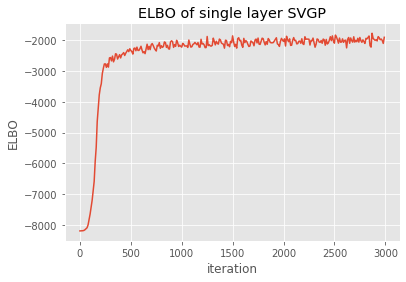

In [15]:
maxiter = ci_niter(3000)
logf, gradients = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of single layer SVGP')

-8195.135717501042
-2150.1405504356717
-2130.455535327291
-2117.548666625895
-2171.9876397279972


Text(0.5, 1.0, 'ELBO of single layer SVGP')

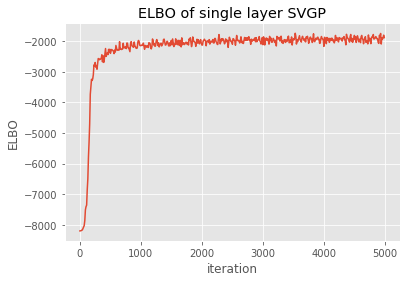

In [69]:
maxiter = ci_niter(5000)
logf, gradients = run_adam(m_500, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of single layer SVGP')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-524746.9194451229
-38374.82418531051
-31022.193321410206
-25974.291138770397
-27743.142415278006
-23256.00665966486
-22110.202786298752
-24603.689702584215
-21913.45015139023
-21562.085600786595



Text(0.5, 1.0, 'ELBO of DGP2')

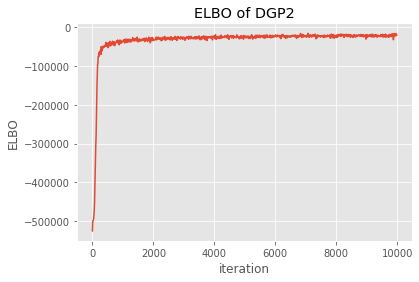

In [17]:
maxiter = ci_niter(10000)
logf_dgp, gradients2 = run_adam_dgp(dgp2_ard, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP2')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-557785.6958401834
-43403.64205568335
-34333.93596623928
-32192.093481467367
-29874.900180366323
-21721.885216494462
-24029.699253666102
-29195.541820617254
-22671.764421953456
-22179.3805326699



Text(0.5, 1.0, 'Gradients of DGP3')

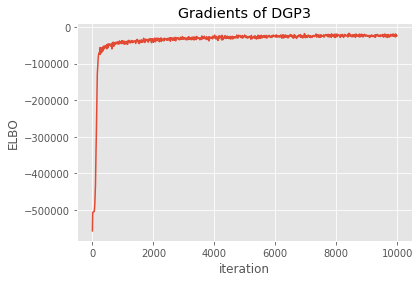

In [52]:
maxiter = ci_niter(10000)
logf_dgp3, gradients_dgp3 = run_adam_dgp(dgp3_ard, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp3)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('Gradients of DGP3')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


-590824.4722352439
-46708.27020126482
-41913.281896488275
-34443.41837908198
-33406.52748510041
-27642.0525551857
-26741.289456330065
-25310.166272043152
-27158.321816405947
-26035.56182219462



Text(0.5, 1.0, 'ELBO of DGP4')

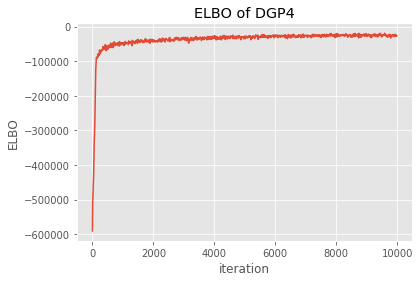

In [34]:
maxiter = ci_niter(10000)
logf_dgp4, gradients4 = run_adam_dgp(dgp4_adam, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp4)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP4')

/homes/rx220/env/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
-590824.4722352439
-508661.0193374167
-504821.37535793084
-501749.39920639026
-499180.059607221
-496983.12444694166
-495131.20091244945
-493657.0678487444
-492612.53637654905
-492010.7122191469



Text(0.5, 1.0, 'ELBO of DGP4')

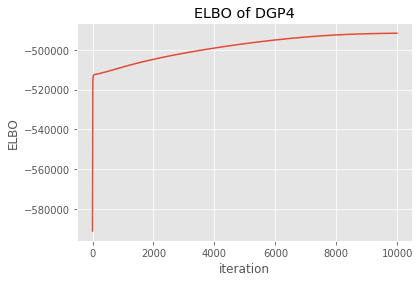

In [17]:
maxiter = ci_niter(10000)
logf_dgp4, gradients4 = run_adam_dgp(dgp4_adam, maxiter)
plt.plot(np.arange(maxiter)[::10], logf_dgp4)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('ELBO of DGP4')

## Test Accuracy
SVGP: simply take the max mean prediction
DGP: We need a single prediction for each datum, so to do this we take $S$ samples for the one-hot predictions ($(S, N, 10)$ matrices for mean and var), then we take the max over the class means (to give a $(S, N)$ matrix), and finally we take the modal class over the samples (to give a vector of length $N$):

In [23]:
def assess_model_sgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch)
    l = model.predict_log_density([X_batch, Y_batch])
    a = (np.argmax(m, 1).reshape(Y_batch.shape).astype(int)==Y_batch.astype(int))
    return l, a

S = 100
def assess_model_dgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch, S)
    l = model.predict_density(X_batch, Y_batch, S)
    a = (mode(np.argmax(m, 2), 0)[0].reshape(Y_batch.shape).astype(int)==Y_batch.astype(int))
    return l, a

def alter_assess_model_dgp(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch, S)
    l = model.predict_density(X_batch, Y_batch, S)
    m = np.average(m, axis=0)
    a = (np.argmax(m, axis=1).reshape(Y_batch.shape).astype(int)==Y_batch.astype(int))
    return l, a

In [24]:
def batch_assess(model, assess_model, X, Y):
    n_batches = max(int(len(X)/1000), 1)
    lik, acc = [], []
    for X_batch, Y_batch in zip(np.split(X, n_batches), np.split(Y, n_batches)):
        l, a = assess_model(model, X_batch, Y_batch)
        lik.append(l)
        acc.append(a)
    lik = np.concatenate(lik, 0)
    acc = np.array(np.concatenate(acc, 0), dtype=float)
    return np.average(lik), np.average(acc)

In [18]:
def predict_prob(model, X_batch):
    m,v = model.predict_y(X_batch)
    return m

S = 100
def predict_prob_dgp(model, X_batch):
    m,v = model.predict_y(X_batch, S)
    m = np.average(m,axis=0)
    return m

def calibrate_curve(model, method, X, Y, bins):
    n_batches = max(int(len(X)/1000), 1)
    pred_prob= []
    for X_batch, Y_batch in zip(np.split(X, n_batches), np.split(Y, n_batches)):
        predict = method(model, X_batch)
        pred_prob.append(predict)
    pred_prob = np.concatenate(pred_prob, 0)
    
    B = {}
    for i in range(bins):
        B[i] = [0,0,0]
    
    for n in range(X.shape[0]):
        for d in range(Y.max()+1):
            whichBin = int(pred_prob[n][d]*bins)
            B[whichBin][0] += 1
            if d == Y[n]: B[whichBin][1] += 1
            B[whichBin][2] += pred_prob[n][d]
    correct = []
    predicted = []
    for i in range(bins):
        correct.append(B[i][1]/B[i][0])
        predicted.append(B[i][2]/B[i][0])
    
    return correct, predicted

In [26]:
correct, predict = calibrate_curve(m, predict_prob, x_test, y_test, 10)

In [27]:
correct_dgp2, predict_dgp2 = calibrate_curve(dgp2_ard, predict_prob_dgp, x_test, y_test, 10)

In [55]:
correct_dgp3, predict_dgp3 = calibrate_curve(dgp3_ard, predict_prob_dgp, x_test, y_test, 10)

In [28]:
correct

[0.0030276517855087146,
 0.08942632170978627,
 0.15547263681592038,
 0.3253012048192771,
 0.45248868778280543,
 0.6072289156626506,
 0.7306843267108167,
 0.8804159445407279,
 0.9184782608695652,
 0.9949748743718593]

In [29]:
predict

[0.0043006899969934105,
 0.14156572121516614,
 0.24698616553512687,
 0.34637357136593344,
 0.45024973026557596,
 0.5499651125947297,
 0.6490545806004976,
 0.7527711544845221,
 0.8552716826617257,
 0.9805189456974015]

In [30]:
correct_dgp2

[0.0010177263322708717,
 0.13818181818181818,
 0.20606060606060606,
 0.25510204081632654,
 0.42528735632183906,
 0.5465116279069767,
 0.65,
 0.7580645161290323,
 0.8221153846153846,
 0.9953399703452658]

In [31]:
predict_dgp2

[0.0006481236050259814,
 0.14386635109825546,
 0.2458229275048019,
 0.34973115130656435,
 0.44970028054286926,
 0.5552385162556382,
 0.6532766041682759,
 0.75667096338125,
 0.8546532514610709,
 0.9951138485288163]

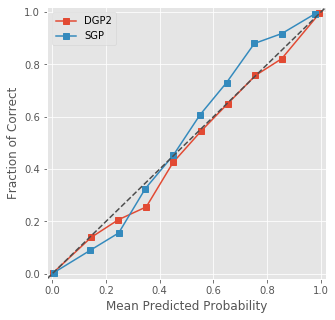

In [32]:
plt.figure(figsize=(5,5))
plt.plot(predict_dgp2, correct_dgp2,'s-',
             label="DGP2")
plt.plot(predict_m, correct_m,'s-',
             label="SGP")

plt.legend()
plt.xlim(-0.02,1.02)
plt.ylim(-0.02,1.02)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Correct")
plt.show()

In [57]:
l, a = batch_assess(dgp2, assess_model_dgp, x_test, y_test)
print('dgp2 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp2 test lik: -0.0778, test acc 0.9789


In [25]:
l, a = batch_assess(dgp2_ard, assess_model_dgp, x_test, y_test)
print('dgp2 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp2 test lik: -0.0782, test acc 0.9773


In [57]:
l, a = batch_assess(dgp3_ard, assess_model_dgp, x_test, y_test)
print('dgp3 ard test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp3 ard test lik: -0.0729, test acc 0.9799


In [65]:
l, a = batch_assess(dgp3, assess_model_dgp, x_test, y_test)
print('dgp3 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp3 test lik: -0.0721, test acc 0.9798


In [39]:
l, a = batch_assess(dgp4_adam, assess_model_dgp, x_test, y_test)
print('dgp4 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

dgp4 test lik: -0.0733, test acc 0.9783


In [18]:
l, a = batch_assess(m, assess_model_sgp, x_test, y_test)
print('sgp test lik: {:.4f}, test acc {:.4f}'.format(l, a))

sgp test lik: -0.2637, test acc 0.9258


In [70]:
l, a = batch_assess(m_500, assess_model_sgp, x_test, y_test)
print('sgp_500 test lik: {:.4f}, test acc {:.4f}'.format(l, a))

sgp_500 test lik: -0.2623, test acc 0.9288


## Visualize all layers

In [27]:
X = np.split(x_test, 10)[0]
Y = np.split(y_test, 10)[0]

In [28]:
s,m,v = dgp2.predict_all_layers(X, 100)

In [29]:
s,m4,v4 = dgp4.predict_all_layers(X, 100)

In [32]:
first_layer = m[0].numpy()

In [33]:
first_layer4 = m4[0].numpy()

In [65]:
first_4_var = v4[0].numpy()
first_var = v[0].numpy()

In [50]:
second_layer4 = m4[1].numpy()

In [57]:
first_4_var.shape

(100, 1000, 30)

In [35]:
first_layer = np.average(first_layer,axis=0)
first_layer4 = np.average(first_layer4,axis=0)

In [66]:
first_4_var = np.average(first_4_var,axis=0)
first_var = np.average(first_var,axis=0)

In [59]:
layer = first_4_var
innerlayer2_var4 = np.zeros((1,30))
for i in range(10):
    digit = layer[(Y==i).reshape(-1),:][:30]
    innerlayer2_var4 = np.concatenate((innerlayer2_var4, digit),axis=0)
    divide = np.zeros((1,30))
    innerlayer2_var4 = np.concatenate((innerlayer2_var4, divide),axis=0)

In [67]:
layer = first_var
innerlayer2_var = np.zeros((1,30))
for i in range(10):
    digit = layer[(Y==i).reshape(-1),:][:30]
    innerlayer2_var = np.concatenate((innerlayer2_var, digit),axis=0)
    divide = np.zeros((1,30))
    innerlayer2_var = np.concatenate((innerlayer2_var, divide),axis=0)

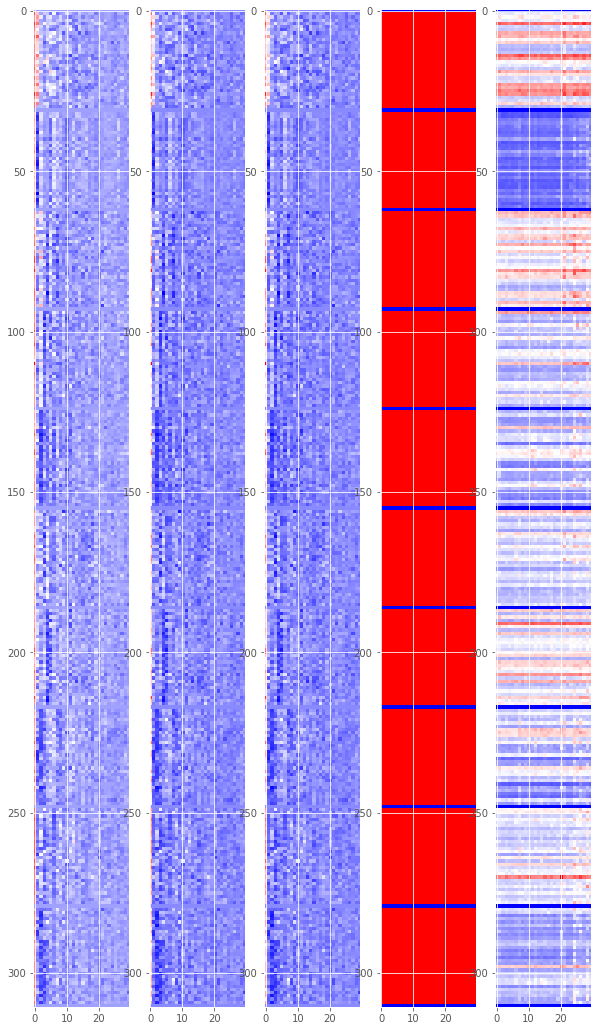

In [71]:
f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(10,20))
ax1.imshow(innerlayer_sample, cmap='bwr')
ax2.imshow(innerlayer_sample4, cmap='bwr')
ax3.imshow(innerlayer2_sample4, cmap='bwr')
ax4.imshow(innerlayer2_var4, cmap='bwr')
ax5.imshow(innerlayer2_var, cmap='bwr')
plt.show()